<div class="alert alert-info"><h4>Note</h4><p> 
    This notebook is still work in progress and the content has not been fact checked! <a href="url">here</a>.
</p></div>

# Linear models and Bayes theorem

We based our previous chapters on an intuitive example: tossing a coin and trying to find whether the probability of head is 0.5, i.e. whether our coin is biased. And we saw that we can use the Bayes Theorem to obtain the probability of each value of $\Theta$ based on the observed data, based on which we can reach a principled decision.

In this chapter, we will use another example to illustrate that even for rather simple models, some terms of the Bayes theorem might not have an analytical solution (you will see what that means in a bit ), making computing the posterior difficult. Importantly, the reason we introduce that is to motivate the use of the bag of tricks this book is about: **Variational Laplace**. Once you understand why we can't simply solve the equation, it should be more intuitive to understand why we need to call on seemingly unrelated concepts.

The example we will use is also based on a simple question: is the length of penguins flippers related to their body mass? The reason we use this problem is two folds. For one, it enables us to illustrate the difficulties of Bayesian statistics with one of the most general model there is: the linear mixed model, which is also the most important for people reading coming from psychology and neuroscience. But also, it might be familiar from other tutorials online because of the Palmer penguin data set, which is used across many tutorials to illustrate basic principles of stats. In this chapter, we will rely on simulation rather than on the actual dataset, but we will get back to the actual data set in a later chapter. 

## The linear model:
To investigate this problem, we will use a linear model, which is defined as:

$$y = \beta_{0} + \beta_{1}x_{1} + \epsilon$$

Where:
- y: the data. In our example, that would be the body mass of the penguin
- $x_{1}$: a correlate. In our example, that would be the flipper length
- $\beta_{1}$: correlation coefficient. If the flipper length is related to the mass of the penguin, then the body weight may be $\beta_{1}$ times the flipper length
- $\beta_{0}$: intercept. If there is a linear relationship between the body weight and the flipper of the penguin, there may be an offset in that relationship (we will see below that that looks like)
- $\epsilon$ error term. The relationship between the flipper length and the body weight probably isn't 1 to 1, so there will be some error remaining that isn't explained by our model

When cast in this way, we can rephrase our question **'is the length of penguins flippers related to their body mass?'** in a more formal way, by saying: **is the parameter $\beta_1$ significantly different from 0?** Just as in our coin toss problem where we wanted to establish the true probability of getting head (to see if it is more or less 0.5), we here want to draw an inference about the true value of $\beta_1$ based our data. But as was the case with our coin toss example, because we are dealing with some degrees of randomness, we can never be sure of what the true value of $\beta_1$ is. Instead, what we have to try to establish is what is the probability of each value of $\beta_1$ based on our data. So once again, we need to apply the Bayes theorem to find:

$$P(\Theta|y)$$

Where this time $\Theta$ are the parameters $\beta_{1}$ and $\beta_{0}$. You might wonder: we only care about $\beta_{1}$, so why worry about $\beta_{0}$. The main reason is that while $\beta_{0}$ doesn't matter for our problem, it will for many other. And while in the current model we have only two betas, there are linear models with many more $\beta$. We will therefore use this example to illustrate that the $\Theta$ in the Bayes theorem can refer to many parameters of a single model and how $P(\Theta|y)$ can refer to the probability of many parameters at once.

## Simulating our data: the linear model in action
Let's suppose that there is a positive correlation between the flipper length and the weight of the penguin. That would make sense, because it seems logical that penguin with larger flippers would be heavier. And also, as we said, we probably won't have a perfect relationship between flipper length and penguin's weight, so there will be some error remaining. So say we have a correlation of 0.19, plus some error, and an intercept of 0, the data would look something like that:

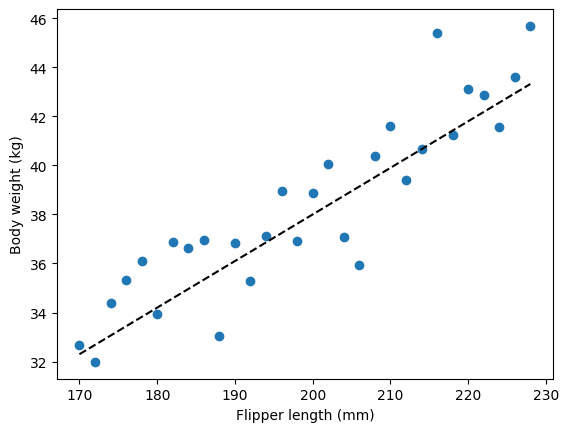

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def linear_mdl(x, beta_0, beta_1, error_mu, error_sigma):
    y = beta_0 + beta_1 * x + np.random.normal(error_mu, error_sigma, size=x.shape[0])
    return y

# Define the parameters for our simulation:
flipper_length_mm = np.arange(170, 230, 2)  # Let's say we collected the flipper length of penguins and that these are between 170 and 230mm
beta_0 = 0  # Intercept
beta_1 = 0.19  # Regression coefficient between flipper length and body weight 
error_mu = 0  # Mean error term
error_sigma = 2  # Error term spread

# Simulate the data:
y = linear_mdl(flipper_length_mm, beta_0, beta_1, error_mu, error_sigma)

# Plot the data:
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y)  # Plot the simulated data
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='k', linestyle='--', label='Regression line')  # Plot the regression line
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
plt.show()
plt.close()

There we go, we have generated semi-realistic data: penguin flippers size is correlated with their body weights. A penguin with flippers of 200mm is going to weight around 36-38kg, while a penguin with flipper lengths of 170mm is most likely going to weight around 32-34kg. That doesn't seem too crazy, but full disclosure I am not a penguin experts, so I have no idea. In comparison, our model could also have a non-zero intercept:

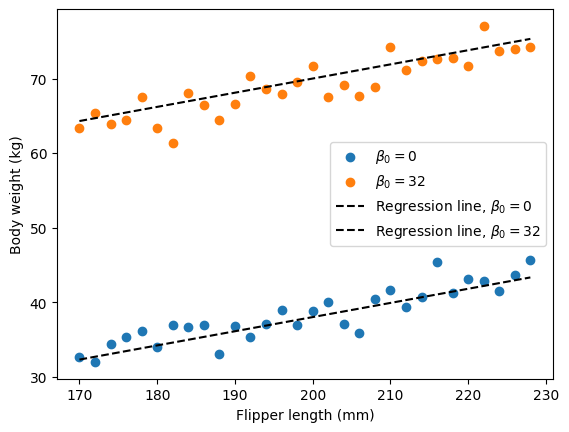

In [2]:
# Define the parameters for our simulation:
non_zero_beta_0 = 32  # Intercept

# Simulate the data:
y_intercept = linear_mdl(flipper_length_mm, non_zero_beta_0, beta_1, error_mu, error_sigma)

# Plot the data:
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y, label='$\\beta_0=0$')  # Plot the simulated data
ax.scatter(flipper_length_mm, y_intercept, label='$\\beta_0=32$')  # Plot the simulated data
ax.plot(flipper_length_mm, 0 + beta_1 * flipper_length_mm, color='k', linestyle='--', label='Regression line, $\\beta_0=0$')  # Plot the regression line
ax.plot(flipper_length_mm, non_zero_beta_0 + beta_1 * flipper_length_mm, color='k', linestyle='--', label='Regression line, $\\beta_0=32$')  # Plot the regression line
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
ax.legend()
plt.show()
plt.close()

You can see that when we modulate the intercept term, we move the line up or down. The intercept as the name indicates refers to the value on the y axis at which our regression line crosses when x is 0. In our penguin example, you can think about it like this: if we had a hypothetical penguin of flipper length 0, would that penguin also weight 0 kg? When you draw your regression line, imagine you extend it until a flipper length of 0mm, the intercept is the weight of such a hypothetical 0mm length penguin according to our model.

There is another very important thing to understand here. If you have used linear models in the past, you might understand them only as a statistical tool: you fit the model to your data, compute some statistics (such as p values) on the beta coefficient to then conclude 'yes there is a relationship between these two variables'. However, a linear model is first and foremost a generative model for the data. You are basically stating a hypothesis that your dependent variable (y) is equal to the independent variable(s) (x) weighted by a particular coefficient ($\beta$) plus some noise. The fitting procedure is used to find the parameters of the model based on the data (more on that later). As we did above, you can also use the linear model to simulate data, by setting parameters that you think are reasonable. You can also fit the model to true data to extract the parameters, and then use the exact same parameters to simulate data based on these realistic parameters (I will show how that's done below). The concept of **generative model** will become very important in the later chapters of the book, so make sure that this is clear (if it's not, you can drop an issue on github to request more detailed info ;)

### Fitting a linear model to retrieve the parameters based on the data

Before we go into the details of the Bayesian part, I will spend a few paragraphs describing the inner workings of a linear model. Feel free to skip if you are very familiar with those. But I would encourage you to read it anyways, because some of the concepts relevant to explain a linear model are very relevant for the Bayesian part that comes later.

When we fit a linear model, we try to find values for the parameters of our model ($\beta_{0}$ and $\beta_{1}$) that minimize the error, that is how off the value predicted by our model are from the actual data. If the $\beta_{1}$ parameter that yields the smallest error is large, chances are the two variables you are looking at are correlated.

Trying to minimize the error means trying to make the distance between each dot and the regression line as small as possible. Here is way to vizualize it:

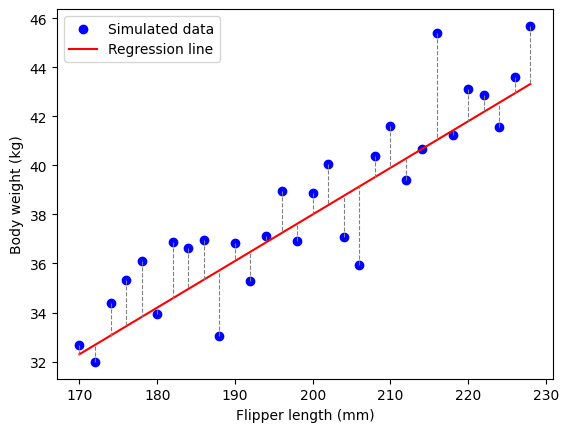

In [3]:
# Plot the data and regression line
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y, label='Simulated data', color='blue')
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='red', label='Regression line')
# Add horizontal lines connecting each data point to the regression line
for i in range(len(flipper_length_mm)):
    ax.plot([flipper_length_mm[i], flipper_length_mm[i]], [y[i], beta_0 + beta_1 * flipper_length_mm[i]], color='gray', linestyle='--', linewidth=0.8)
# Set labels and legend
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
ax.legend()
# Show plot
plt.show()
plt.close()

That way, you can see that for each penguin (i.e. each dot), their weight is $\beta_1 * Flipper\ Length + some\ error$. If you take the left most dot, the weight is $170*0.19=32.3kg$ to which you add (or sutract) some error. That little something is the error, and we need to find the parameter of our model so that the sum of the vertical distance between each dot and the regression line is as small as possible. Because we are working with simulated data, the best parameters should be close to the one we selected. And if we choose any other parameters (different values for $\beta_0$ and $\beta_1$), the error should be larger:

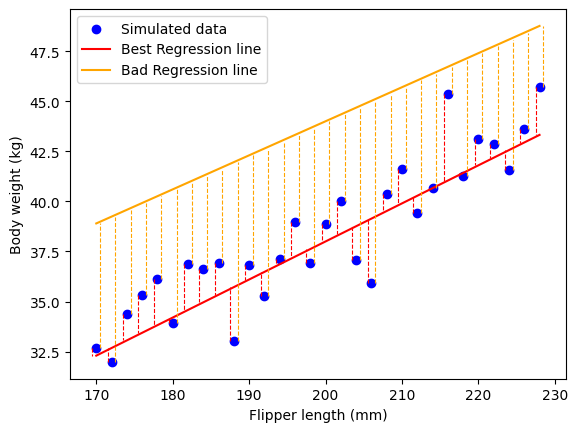

In [4]:
# Create wrong parameters:
wrong_beta_0 = 10
wrong_beta_1 = 0.17

fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y, label='Simulated data', color='blue')
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='red', label='Best Regression line')
ax.plot(flipper_length_mm, wrong_beta_0 + wrong_beta_1 * flipper_length_mm, color='orange', label='Bad Regression line')
# Add horizontal lines connecting each data point to the regression line
for i in range(len(flipper_length_mm)):
    ax.plot([flipper_length_mm[i]-0.5, flipper_length_mm[i]-0.5], [y[i], beta_0 + beta_1 * flipper_length_mm[i]], color='red', linestyle='--', linewidth=0.8)
    ax.plot([flipper_length_mm[i]+0.5, flipper_length_mm[i]+0.5], [y[i], wrong_beta_0 + wrong_beta_1 * flipper_length_mm[i]], color='orange', linestyle='--', linewidth=0.8)
# Set labels and legend
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
ax.legend()
# Show plot
plt.show()
plt.close()

You can see that the distance between the orange line and each dot is larger than the distance between the red line for most points. There are a few points where that is not the case, but on average, it's easy to see that red line does a better job than the orange one. Formally, when we try to minimize the error, we try to minimize the **residual sum of square error**:

$$RSS = \sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

Which is basically saying we try to find the parameters $\beta_0$ and $\beta_1$ such that the sum of the difference between each blue dot ($y_i$) and the value predicted by the line ($\hat{y_i}$) is as small as possible. And we take the square of the difference such that it doesn't matter if the prediction is more or less than the true value. So you can imagine that fitting a linear model is trying all possible combinations of values of $\beta_0$ and $\beta_1$ (and other $\beta$ if you have several regressors) and for each compute the **RSS** and pick those values. And if the best parameters entail a large value for $\beta$, chances are that your two variables are correlated.

I think this description is nice to understand how we fit a linear model, i.e. how do we know which values should we choose for our parameters when we are given two random variables? But in practice, we don't actually try all possible combinations of $\beta_0$ and $\beta_1$. That is because it's simply impossible. As we saw in the previous chapters, $\beta_0$ and $\beta_1$ are continuous variables, meaning that there is an infinity of parameters to choose from. And also, we have two parameters to consider, so we have many possible combinations. Furthermore, while in our example we have only $\beta_0$ and $\beta_1$, you can have as many $\beta$ as you want. So overall, it quickly becomes impractical to try out all possible combinations, it would take an insane amount of time.

And it turns out we really don't have to, because once again someone figured out a simple math formulae to select the parameters of our model based on the input data without having to try all combination. This is achieved in a very similar way to what we did in the previous chapters. We won't go into all the details here (But consult this supplementary chapter if you are interested), but in a nutshell, you have the function:

$$y = \beta_{0} + \beta_{1}x_{1} + \epsilon$$

And you try to find:

$$RSS = \sum_{i=1}^{n}y_i-(\beta_{0} + \beta_{1}x_{1})^2$$

Such that RSS is as small as possible. And it turns out that that is:

$$\hat{\beta_1} = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$$

$$\hat{\beta_0} = \bar{y} - \hat{\beta_1}\bar{x}$$

Where $\bar{x}$ and $\bar{y}$ stand for the mean of x and y respectively. This method is called the **optimal least square (OLS)** solution, as it yields the parameters of our model that yield the lowest sum of suqare errors. 

We can try it out programatically. If this formula works, we should retrieve values that are close from the parameters we used to generate the data:

In [5]:
def fit_linear_model(y, x):
    # Calculate beta_1:
    beta_1 = np.sum((x-np.mean(x))*(y-np.mean(y))) / np.sum((x-np.mean(x))**2)
    # Calcuate beta_0:
    beta_0 = np.mean(y) - beta_1 * np.mean(x)

    return beta_0, beta_1

beta_0, beta_1 = fit_linear_model(y, flipper_length_mm)
print(f'Estimated beta_1={np.round(beta_1, 3)}')
print(f'Estimated beta_0={np.round(beta_0, 3)}')

Estimated beta_1=0.189
Estimated beta_0=0.665


As you can see, close enough, but perhaps surprisingly not exactly the same. This is because of the noise parameter, which makes it such that the data aren't exactly along the line. Accordingly, despite the true parameter of $\beta_1$ being 0.19, we don't get exactly that out when we fit the model. In fact, this is exactly the same idea as with the coin toss we had before: if we throw the coin 100 times, even if the true probability of getting head is 0.5 we don't always get 50% head in each experiment. In the current case, despite the true parameters beta being 0.19, because we only measured a few penguins, we don't get exactly the true parameter our anymore. And just as before, the whole question is: based on my data, how can I be confident that the true value of beta_1 is within a particular range? If our hypothesis is that there is a positive association between flipper size and body weight, we are predicting that it is most likely that beta_1 is more than 0. 

### The error term
One thing I have explained is the error term, or the 'noise' $\epsilon$. The function `linear_mdl` takes two parameters: mean (or $\mu$) and spread (or $\sigma$). In a linear model, we are stating that the data are equal to $\beta_0 + \beta_1x + \epsilon$, and this $\epsilon$ is the reason why the dots above don't fall exactly on the line. For our problem, what could this error be? Well there can be an infinity of reasons why the weight of a penguin isn't fully determined by its flipper length. The weight of a penguin surely depends strongly on food availability for example. And food availability depends on the season: in fish season, penguins are probably a bit heavier than when there is little fish around. Furthermore, the weight of a penguin might also depends from its life history more than its flipper length: a penguin that had a comfortable life might be a bit chubbier, while a penguin that got dealt poorer cards in life might be a bit lighter (disclaimer: I am not proposing to eat the rich). And surely the length of the flipper might depend on genetic factors that are independent from the weight: some penguin may have quite disproportionately long flippers, the michael phelps of penguins if you like. None of these additional parameters are taken into account for our model, which results in some error.

The point is that whatever variation isn't described by $\beta_0$ and $\beta_1$ falls into the error term, which is random. But as we saw in the previous chapters, a random variables most often follows a particular probability distribution. Which one should that be for our model? The answer is the **Normal distribution**. If you heard about variational Laplace and were interested enough to keep reading until now, I would guess you know what the normal distribution is. If by a miracle you haven't, let's just say it is the single most important probability distribution in the world. You will encounter it times and times again, in this book and beyond. The formulae of the normal distribution is the following:

$$P(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

In probability theory linguo, we say that it is a type of continuous probability distribution for real-valued random variables, which means that it is a distribution for continuous variables defined between $-\infty$ and $+\infty$. In other words, it is kind of the default distribution for any random variables that can take any values within that range. If you want to get a better understanding of why the normal distribution describes so many different processes, check out this youtube [video](https://www.youtube.com/watch?v=zeJD6dqJ5lo&list=PL4cNQ1YkG5WhQGmPnRe4vDUImh_nviriy&index=5) (and please check out more videos from that channel). Ah and one last thing, the normal distribution is said to be **Gaussian**, read 'it is shaped like a bell'.

Again, quite simple to implement programmatically:

In [6]:
def normal_pdf(x, mu, sigma):
    p_x = (1/(np.sqrt(2*np.pi*sigma**2))) * np.e**(-((x-mu)**2)/(2*sigma**2))
    return p_x

Now let's have a look at what that distribution looks like:

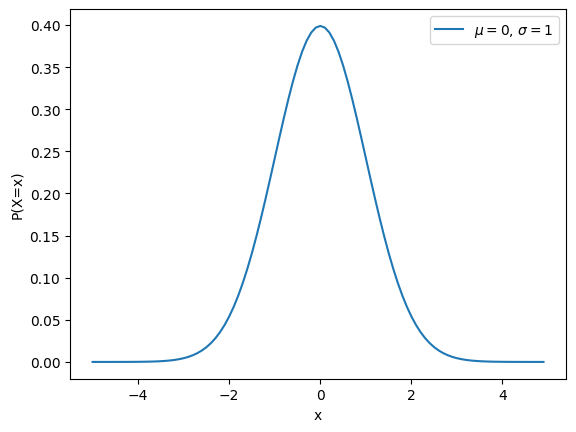

In [7]:
xs = np.arange(-5, 5, 0.1)  # Define values of x
mu = 0
sigma = 1

# Compute the probability of each value of x:
pdf = [normal_pdf(x, mu, sigma) for x in xs]

fig, ax = plt.subplots()
ax.plot(xs, pdf, label=f'$\\mu=0$, $\\sigma=1$')
ax.set_ylabel('P(X=x)')
ax.set_xlabel('x')
ax.legend()
plt.show()
plt.close()

The shape of the curve is familiar, it looks like the beta distribution we used before as our prior, except the beta distribution was limited to values between 0 and 1. In this case, there is no limits. When you think about it, it kinds of make sense. In the model above, the use of a normal distribution is basically saying 'it is most likely that the error of our model is small'. The flipper weight of the penguin isn't expected to fall exactly on the regression line, because that would entail that penguins weight is fully determined by their flipper length. But at the same time, it probably isn't very likely to have a penguin with flipper length 170mm that weight 200 kg. Provided that we have fitted a linear model to our data and that there is a linear relationship between the two variables of interest, values that are far away from our predictions are less likely than values close around it. 

Now of course, all of this is relative. For some cases, you may have very tight correlation between the two variables, which would mean that the independent variable (x) is one of the main factor determining your dependent variable (y), in which case you may have a small error. But in other cases, you may have a not so tight correlation, meaning that while the two variables of interest might be related to one another, there may be a lot of error remaining. One important thing to understand when it comes to linear model is that the strength of the $\beta$ alone doesn't tell you anything about the strength of the association between your two variables. You may have two variables that are very strongly associated but with a small $\beta$, or you may have variables that are not so strongly associated but have high better. 

And as you can see in the `linear_mdl` function and in the formulae of the normal distribution, there are two important parameters: $\mu$ and $\sigma$. The mean parameter $\mu$ specifies the middle of the distribution, and the spread parameter $\sigma$ controls the width of the distribution. We can illustrate it by plotting the same distribution with different parameters:

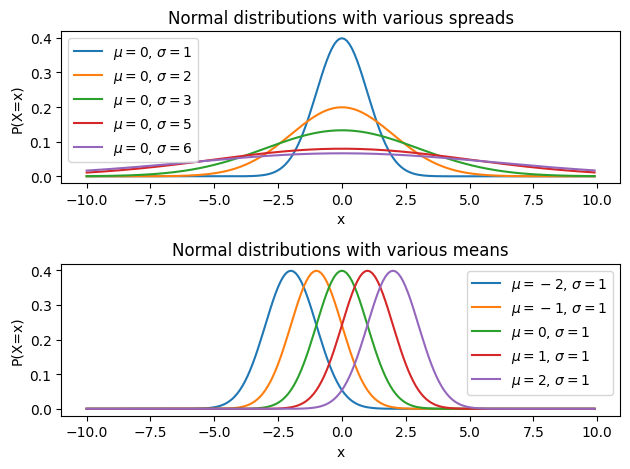

In [8]:
xs = np.arange(-10, 10, 0.1)  # Define values of x

fig, ax = plt.subplots(2)
ax.flatten()
for sig in [1, 2, 3, 5, 6]:
    ax[0].plot(xs, [normal_pdf(x, 0, sig) for x in xs], label=f'$\\mu=0$, $\\sigma={sig}$')
ax[0].set_ylabel('P(X=x)')
ax[0].set_xlabel('x')
ax[0].legend()
ax[0].set_title('Normal distributions with various spreads')
for mu in [-2, -1, 0, 1, 2]:
    ax[1].plot(xs, [normal_pdf(x, mu, 1) for x in xs], label=f'$\\mu={mu}$, $\\sigma=1$')
ax[1].set_ylabel('P(X=x)')
ax[1].set_xlabel('x')
ax[1].legend()
ax[1].set_title('Normal distributions with various means')
plt.tight_layout()
plt.show()
plt.close()

In the simulated data, we chose $\mu=0$ and $\sigma=2$. Importantly, in linear model, the mean of the error term should always be 0, which means that the error should oscillate around 0. This makes sense: even if your model doesn't capture the data really well, you would still expect the dots to be randomly distributed around your regression line. If all the dots were above the regression line, that would be strange and it would in fact indicate that something is very wrong with your model or with your data. We won't go into the why, but the one big assumption of linear model is that the error follows a normal distribution centered on zero.

On the other hand, the $\sigma$ parameter depends on your data: if your model captures the data really well, then the error should be on average closer to zero, which implies that probability of large errors is lower, which in turn implies that the error follows a normal distribution with a small $\sigma$. On the other hand, if you have a model that doesn't capture the data really well, then you'd expect the error to follow a normal distribution with a large error. We can illustrate all of that simply. First, let's look at the **empirical distribution** of the error of our model in the example above:

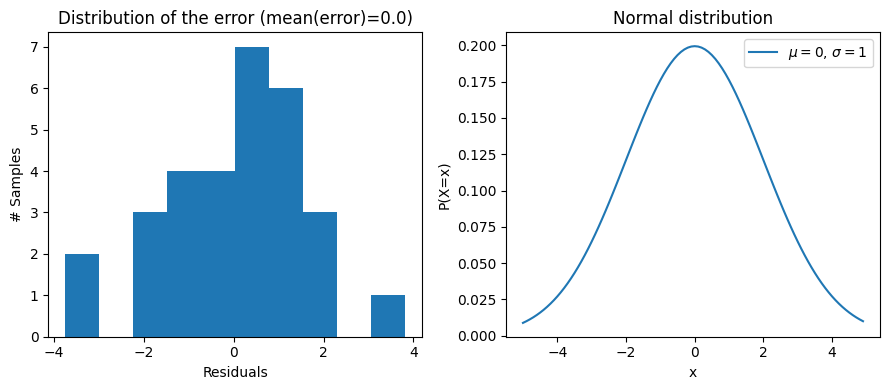

In [9]:
error = y - (beta_0 + beta_1 * flipper_length_mm)  # Calculate the error: the data - the predicted values (i.e. beta_0 + beta_1 x flipper length)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].hist(error)
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('# Samples')
ax[0].set_title(f'Distribution of the error (mean(error)={np.round(np.mean(error), 2)})')

ax[1].plot(np.arange(-5, 5, 0.1), [normal_pdf(x, 0, 2) for x in np.arange(-5, 5, 0.1)], label=f'$\\mu=0$, $\\sigma=1$')
ax[1].set_ylabel('P(X=x)')
ax[1].set_xlabel('x')
ax[1].set_title('Normal distribution')
ax[1].legend()
plt.tight_layout()
plt.show()
plt.close()

We can see that indeed, the mean error is close to 0 and that the error values are between -5 and 5. And when you look at the normal distribution on the right, it looks possible that the error was sampled from such a distribution. They don't look exactly the same, but that's because the residuals are only a few samples. If we had many more obstractions, we would get the left to look closer to the right.

In the simulation, we chose a $\sigma=2$, which is completely arbitrary, just to illustrate the various points. We can easily simulate data with other parameters to illustrate what that would look like and the impact of sigma on the error:

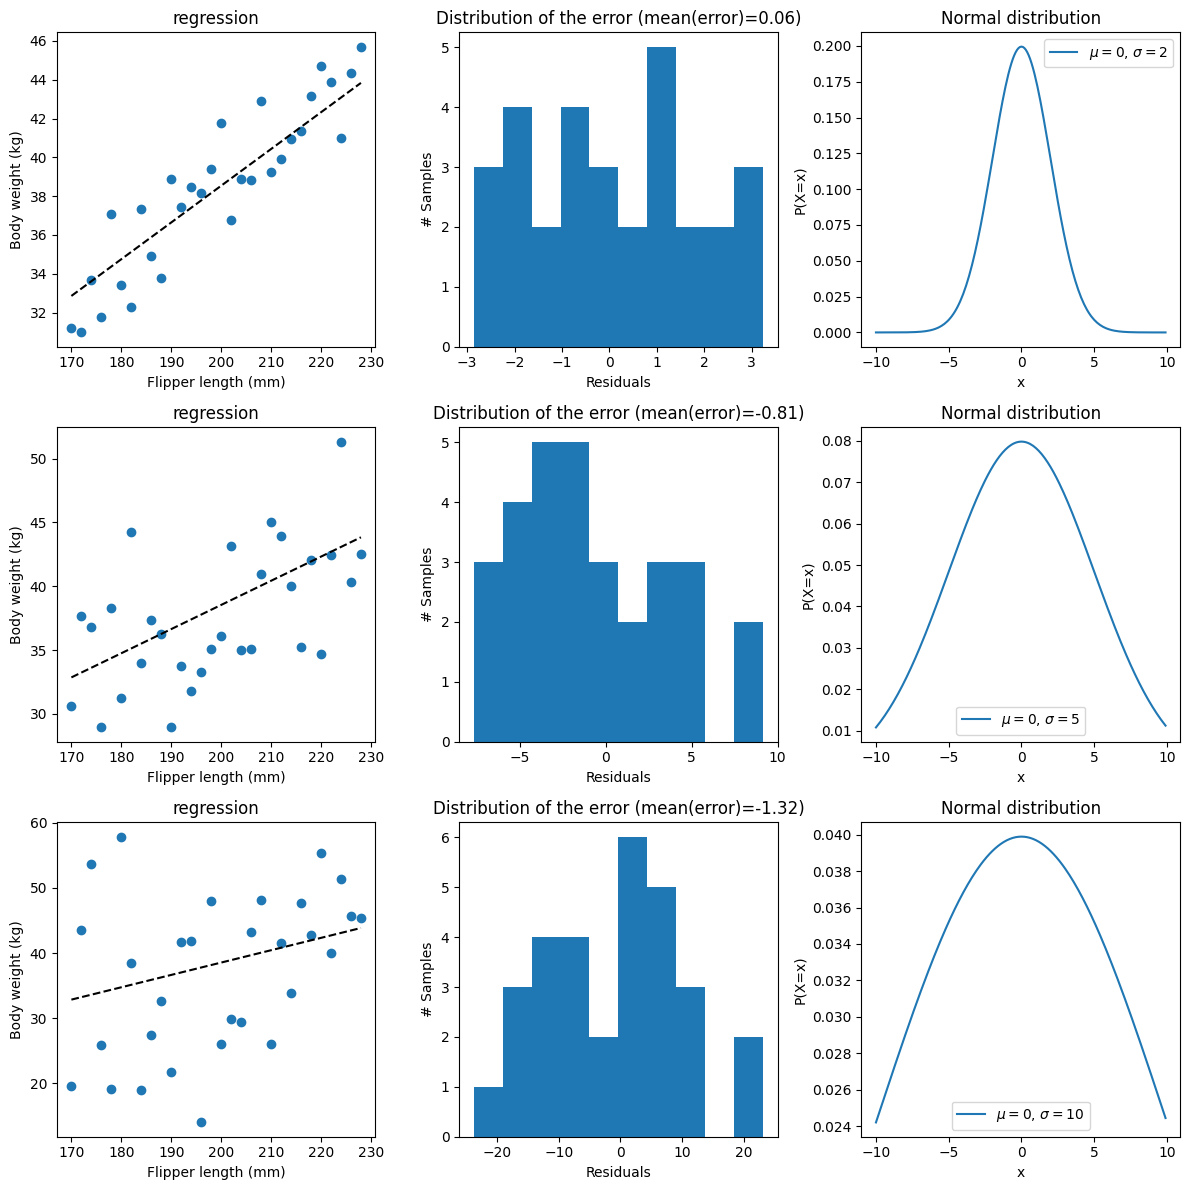

In [10]:
# Simulate the data with various noise levels:
sigmas = [2, 5, 10]
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, sigma in enumerate(sigmas):
    y = linear_mdl(flipper_length_mm, beta_0, beta_1, error_mu, sigma)
    error = y - (beta_0 + flipper_length_mm * beta_1)

    # Plot regression:
    ax[i, 0].scatter(flipper_length_mm, y)  # Plot the simulated data
    ax[i, 0].plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='k', linestyle='--', label='Regression line')  # Plot the regression line
    ax[i, 0].set_xlabel('Flipper length (mm)')
    ax[i, 0].set_ylabel('Body weight (kg)')
    ax[i, 0].set_title('regression')

    # Plot error:
    ax[i, 1].hist(error)
    ax[i, 1].set_xlabel('Residuals')
    ax[i, 1].set_ylabel('# Samples')
    ax[i, 1].set_title(f'Distribution of the error (mean(error)={np.round(np.mean(error), 2)})')

    # Plot the true error distribution:
    ax[i, 2].plot(np.arange(-10, 10, 0.1), [normal_pdf(x, 0, sigma) for x in np.arange(-10, 10, 0.1)], label=f'$\\mu=0$, $\\sigma={sigma}$')
    ax[i, 2].set_ylabel('P(X=x)')
    ax[i, 2].set_xlabel('x')
    ax[i, 2].set_title('Normal distribution')
    ax[i, 2].legend()
plt.tight_layout()
plt.show()
plt.close()

As expected, the larger the sigma, the more spread and the more 'noisy' the data are.

So hopefully, we this you should understand each bit of the linear model. We can now move on to the Bayes theorem part to try and get the probability of the parameters given the (simulated) data

### The linear model in vector form
One last thing before we get started though. The expression we have used for the linear model above is only one way to write it down. There is another way that is a bit more convenient, but requires a bit of knowledge and skill in matrix algebra. Previously, we wrote the model as:

$$y = \beta_0 + \beta_1x + \epsilon$$

where:
- $y$: the data (weight of the penguin)
- $\beta_0$: the intercept parameter, to be estimated (weight of a penguin with flipper length 0 according to our model)
- $\beta_1$: regression coefficient between $y$ and $x$, to be estimated (for each unit increase in flipper length, what is the change in body weight)
- $x$: regressor, fixed, i.e. this will not be estimated by our model (flipper length of each penguin)
- $\epsilon$: error, whatever isn't captured by our model, to be estimated (difference between the actual body weight of our penguin and what our model expected)

Note that for our problem, there is only one $x$, but generally speaking, we would call it $x_1$, because there may be several regressor. For example, after you ran your model to look at the weight of penguin as a function of their flipper length, you might realize that actually, a better model would also take into account the size of their feet, so you could add another regressor with its own beta $\beta_2x_2$ referring to the feet sizes. One way to vizualize the model is this:

|penguins | y (body weight)  = | $\beta_0$ * | $x_0$ + | $\beta_1$ * | $x_1$ (flipper length) + | $\epsilon$ |
| -------- | ------- | -------- | ------- | -------- | ------- | -------- | 
|penguin 1|  62kg  |  ???? | 1 | ????| 170 | ????|
|penguin 2|  70kg  |   | 1 | | 175 | ????|
|penguin 3|  66kg  |   | 1 | | 180 | ????|
|penguin 4|  72kg  |   | 1 | | 185 | ????|

We have the body weight of each penguin, as well as their flipper lengths, and we try to figure out what is the one value we can multiply their flipper length with to get their body weight by. Note that I have added $x_0$ for the intercept, this is only 1, because the intercept is a constant to this model. So if $\beta_0=0.5$, that just makes sure that we add 0.5 to the body weight of every single penguin. Note that if we have many $x$ and $\beta$, the final results would just be the sum of all of that plus some error.

We can rewrite the linear model as such:

$$y =  X\Beta + \epsilon$$

This is exactly the same thing, except this time, xs and betas are matrices. So in other words, we have:

$$
\begin{bmatrix}
y_1\\
y_2\\
y_3\\
y_4\\
\end{bmatrix}
=


\begin{bmatrix}
1 & x_{1, 1}\\
1 & x_{1, 2}\\
1 & x_{1, 3}\\
1 & x_{1, 4}\\
\end{bmatrix}
\times
\begin{bmatrix}
\beta_0\\
\beta_1
\end{bmatrix}

+

\begin{bmatrix}
\epsilon_1\\
\epsilon_2\\
\epsilon_3\\
\epsilon_4\\
\end{bmatrix}

$$

If you aren't familiar with matrix operations, that might not be terribly obvious. But in matrix algebra, there a few specific rule about how you are supposed to muliply and combine matrices together. In our specific case, when you have:

$$
\begin{bmatrix}
1 & x_{1, 1}\\
1 & x_{1, 2}\\
1 & x_{1, 3}\\
1 & x_{1, 4}\\
\end{bmatrix}
\times
\begin{bmatrix}
\beta_0\\
\beta_1
\end{bmatrix}
$$

what you have to do is multiply the first column of the $X$ matrix by $\beta_0$, then the second column of the $X$ matrix by $\beta_1$ and then take the sum of the two column. So that's basically the exact same thing as we did before. It's just a more compact notation, especially because if you have many regressors, the same formulae:

$$y =  X\Beta + \epsilon$$

Only this time you have more columns in your $X$ matrix, and as many $\Beta$ as you have columns in x. Don't worry too much if that's a bit confusing, it's really just a question of notation, and you can always stick to the more 'classical notation' if that's what you prefer. In what follows, I will always provide both notations to make it easier. 